# Working with PyTorch on CIFAR100 dataset
A dataset of 32x32 rgb images with 100 classes.
https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
!pip install git+https://github.com/netbrainml/nbml.git
from IPython.display import clear_output
from nbml.workshops.cifar100.utils import *
from nbml.workshops.models.mlp import *
clear_output()

In [2]:
from keras.datasets import cifar100
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
x_train, x_test = x_train/255, x_test/255
shapes(x_train, x_test, y_train, y_test)

169009152/169001437 [==============================] - 11s 0us/step
arg_0: (50000, 32, 32, 3)
arg_1: (10000, 32, 32, 3)
arg_2: (50000, 1)
arg_3: (10000, 1)


In [3]:
from torch.utils.data import DataLoader, TensorDataset
x_train, x_test = torch.Tensor(x_train).transpose(-1,1), torch.Tensor(x_test).transpose(-1,1)
y_train, y_test = torch.Tensor(y_train).squeeze(), torch.Tensor(y_test).squeeze()

tdl = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True)
vdl = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=True)

In [4]:
def conv(ni,nf): return nn.Sequential(nn.Conv2d(ni,nf,3,1), nn.ReLU(inplace=True), nn.MaxPool2d(2,2))
class CNN(BasicTrainableClassifier):
    def __init__(self, ni, nc):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(ni,128,3,1),
                                  conv(128,256), conv(256,512),
                                  conv(512,1024))
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.fc = MLP(get_layers(1024,512,100,256))
        
    def forward(self, X):
        return self.fc(torch.flatten(self.pool(self.conv(X)),start_dim=1))

In [5]:
cnn_m = CNN(3,100).cuda()
cnn_m

CNN(
  (crit): CrossEntropyLoss()
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (pool): AdaptiveMaxPool2d(output_size=1)
  (fc): MLP(
    (crit): CrossEntropyLoss()
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (

In [6]:
cnn_m.fit(tdl, valid_ds=vdl, epochs=5,
            cbs=True, learning_rate=1e-4)

100% (782 of 782) |######################| Elapsed Time: 0:00:18 Time:  0:00:18
100% (782 of 782) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (157 of 157) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Epoch 1:
	Train Loss: 4.373 | Train Acc: 6.00%
	 Val. Loss: 4.377 |  Val. Acc: 5.99%


100% (782 of 782) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (782 of 782) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (157 of 157) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Epoch 2:
	Train Loss: 4.181 | Train Acc: 11.25%
	 Val. Loss: 4.191 |  Val. Acc: 10.77%


100% (782 of 782) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (782 of 782) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (157 of 157) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Epoch 3:
	Train Loss: 4.056 | Train Acc: 14.12%
	 Val. Loss: 4.087 |  Val. Acc: 12.92%


100% (782 of 782) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (782 of 782) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (157 of 157) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Epoch 4:
	Train Loss: 3.968 | Train Acc: 16.46%
	 Val. Loss: 4.018 |  Val. Acc: 15.23%


100% (782 of 782) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (782 of 782) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (157 of 157) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Epoch 5:
	Train Loss: 3.887 | Train Acc: 18.34%
	 Val. Loss: 3.949 |  Val. Acc: 16.73%


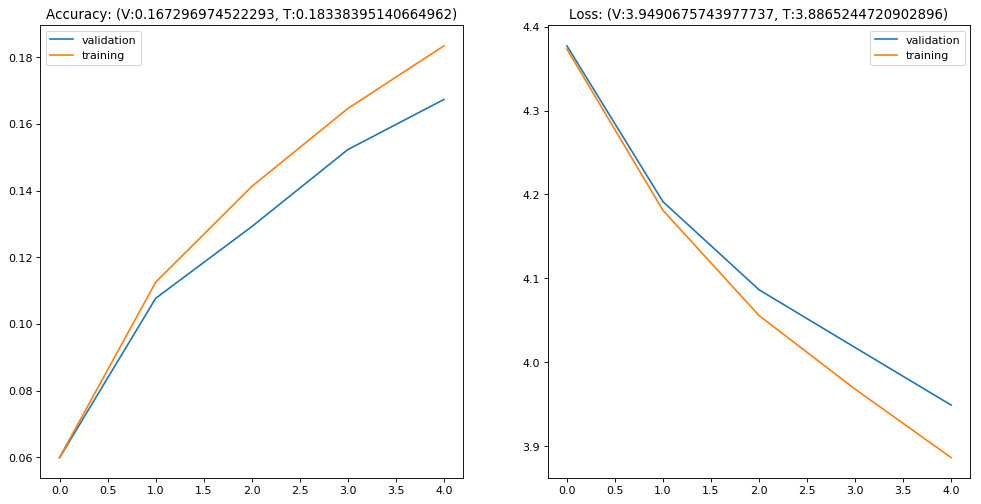

In [7]:
cnn_m.plot